In [21]:
import os
import nltk
import math
import pandas as pd
import numpy as np

from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, \
    confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import keras as K

from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Dropout, BatchNormalization, Activation, Input, \
    Conv1D, MaxPool1D, Flatten, Concatenate, Add
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

from google.colab import drive
drive.mount('/content/gdrive')

import spacy
nlp = spacy.load('en_core_web_sm')
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
def load_data(file_name):
    """
    :param file_name: a file name, type: str
    return a list of ids, a list of reviews, a list of labels
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    """
    df = pd.read_csv(file_name)

    return df["business_id"], df["text"], df["stars"]

def load_labels(file_name):
    """
    :param file_name: a file name, type: str
    return a list of labels
    """
    return pd.read_csv(file_name)["stars"]

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)), pred))
    df.columns = ["id", "stars"]
    df.to_csv(file_name, index=False)

In [23]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    # .most_common(): List the n most common elements and their counts from the most common to the least.
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        try:
            vector[i] = feats_dict[f]
        except KeyError:
            vector[i] = 1
    return vector

In [24]:
def build_CNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              kernel_sizes, num_filters, num_mlp_layers,
              padding="valid",
              strides=1,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param kernel_sizes: the kernel sizes of convolutional layers, type: list
    :param num_filters: the number of filters for each kernel, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param padding: the padding method in convolutional layers, type: str
    :param strides: the strides in convolutional layers, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a CNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # convolutional layers document: https://keras.io/layers/convolutional
    # pooling layers document: https://keras.io/layers/pooling/
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    emb = Embedding(input_dim=vocab_size, output_dim=embedding_size)(x)
    
    ################################
    ########### Conv-Pool ##########
    ################################
    # convolutional and pooling layers
    cnn_results = list()
    for kernel_size in kernel_sizes:
        # add convolutional layer
        conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, strides=strides)(emb)
        # add batch normalization layer
        if batch_norm:
            conv = BatchNormalization()(conv)
        # add activation
        conv = Activation(activation)(conv)
        # add max-pooling
        maxpool = MaxPool1D(pool_size=(input_length-kernel_size)//strides+1)(conv)
        cnn_results.append(Flatten()(maxpool))
    
    ################################
    ##### Fully Connected Layer ####
    ################################
    h = Concatenate()(cnn_results) if len(kernel_sizes) > 1 else cnn_results[0]
    h = Dropout(dropout_rate, seed=0)(h)
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [25]:
train_file = "/content/gdrive/MyDrive/COMP4332PA1/train.csv"
val_file = "/content/gdrive/MyDrive/COMP4332PA1/valid.csv"
min_freq = 3

# load data

train_ids, train_texts, train_labels = load_data(train_file)
val_ids, val_texts, val_labels = load_data(val_file)

# extract features
train_tokens = [tokenize(text) for text in train_texts]
val_tokens = [tokenize(text) for text in val_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
val_stemmed = [stem(tokens) for tokens in val_tokens]

train_feats = [filter_stopwords(tokens) for tokens in train_stemmed]
val_feats = [filter_stopwords(tokens) for tokens in val_stemmed]

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)

Size of features: 9225


Text(0, 0.5, 'Cumulative Numbers')

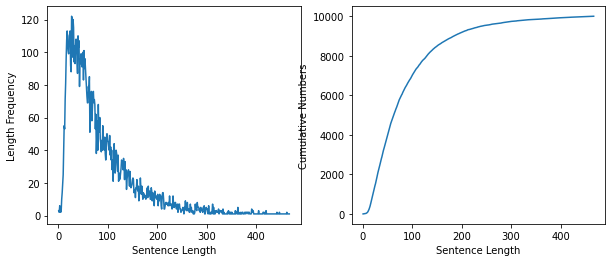

In [26]:
plt.figure(figsize=(10,4))
len_cnt = Counter([len(feats) for feats in train_feats])
len_key = sorted(len_cnt)
plt.subplot(1,2,1)
plt.plot(range(1, len(len_key)+1),
         [len_cnt[l] for l in len_key])
plt.xlabel("Sentence Length")
plt.ylabel("Length Frequency")

plt.subplot(1,2,2)
plt.plot(range(1, len(len_key)+1),
         np.cumsum([len_cnt[l] for l in len_key]))
plt.xlabel("Sentence Length")
plt.ylabel("Cumulative Numbers")

In [27]:
max_len = 200

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
val_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in val_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
val_label_matrix = keras.utils.to_categorical(val_labels-1, num_classes=num_classes)

In [28]:
os.makedirs("models", exist_ok=True)
model = build_CNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  kernel_sizes=[2,3,4], num_filters=100, num_mlp_layers=3,
                  activation="relu",
                  dropout_rate=0.5, l2_reg=0.005, batch_norm=True)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

np.random.seed(0)
tf.random.set_seed(0)
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=30, batch_size=100, verbose=0,
                    callbacks=[checkpointer])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)


100/100 [==============================] - 1s 6ms/step - loss: 0.6492 - accuracy: 0.7711


In [29]:
val_score = model.evaluate(val_feats_matrix, val_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", val_score[0], "validation accuracy", val_score[1])

20/20 [==============================] - 0s 6ms/step - loss: 1.0371 - accuracy: 0.6115
training loss: 0.6491913199424744 training accuracy 0.7710999846458435
validation loss: 1.0370895862579346 validation accuracy 0.6115000247955322


[0.23499999940395355, 0.20399999618530273, 0.21799999475479126, 0.3440000116825104, 0.4309999942779541, 0.4480000138282776, 0.5019999742507935, 0.47999998927116394, 0.531000018119812, 0.5429999828338623, 0.527999997138977, 0.5109999775886536, 0.5350000262260437, 0.5509999990463257, 0.5490000247955322, 0.5580000281333923, 0.5509999990463257, 0.5559999942779541, 0.5479999780654907, 0.5669999718666077, 0.5590000152587891, 0.5659999847412109, 0.5519999861717224, 0.5699999928474426, 0.5669999718666077, 0.5649999976158142, 0.531000018119812, 0.5410000085830688, 0.5709999799728394, 0.5630000233650208]


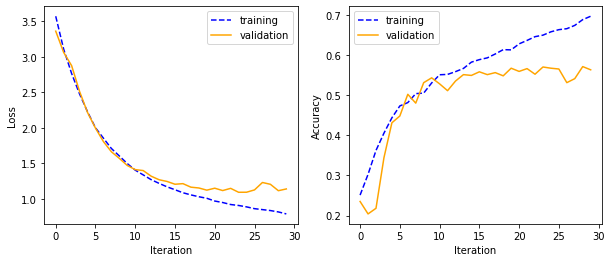

In [30]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_loss"], label="validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
acc = np.array(history.history["accuracy"])
val_acc = np.array(history.history["val_accuracy"])
plt.plot(acc, label="training", color="blue", linestyle="dashed")
print(history.history["val_accuracy"])
plt.plot(val_acc, label="validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()